In [34]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt

Data Processing

In [42]:
# Load the dataset in
wine_data = load_breast_cancer()
X = np.array(wine_data['data'], requires_grad=True)
Y = np.array(wine_data['target'], requires_grad=True)
Y = np.where(Y < 1, -1 , 1) # Convert into a binary problem

# Compress the data into 2 principal components, for 2 Qubit Computation
pca = PCA(n_components=2)
X = pca.fit_transform(X)
retained_variance = sum(pca.explained_variance_ratio_)
print("Variance retained: {:.2f}".format(retained_variance*100))

# Min Max Scale the X input
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Variance retained: 99.82


In [43]:
# Define function to map classical data into angles, for encoding into Quantum States
def get_angles(x):
    # Thought process:
    # Assuming that the basis of classical data is [0,1] and [1,0]
    # We compute the sin (opposite / hypothenuse)
    # Arcsin to get theta value back
    # The betas are from the bloch sphere? <- not sure
    beta0 = 2 * np.arcsin(np.sqrt(x[1] **2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] **2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    ) 
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def statepreperation(a):
    """
    a (array) : angles from get_angles()
    """
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0,1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [44]:
# Testing the above defined funcs
x = np.array([0.55, 0.79, 0.278, 0.0], requires_grad=False)
ang = get_angles(x)

## Creating a device ##
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def test(angles):

    statepreperation(angles)

    return qml.expval(qml.PauliZ(0))

test(ang)

print("Original input:",x)
print("Angle Transformation:",ang)
print("Mapping back to real space:",np.real(dev.state))

Original input: [0.55  0.79  0.278 0.   ]
Angle Transformation: [ 0.56230211 -0.          0.         -0.96262355  0.96262355]
Mapping back to real space: [ 5.48935001e-01  7.88470275e-01  2.77461692e-01 -1.38777878e-17]


In [45]:
## Mapping compressed wine data features into Quantum Space ##

print("Recap on how the data looks like", X[0])

# pad the vectors to size 2^2 with constant values
# n qubits circuit -> vectors must be shape N -> 2^n = N, hence 2^2 = 4
padding = 0.3 * np.ones((len(X), 1)) # produces a (m,1) vector of 0.3
X_pad = np.c_[np.c_[X,padding], np.zeros((len(X),1))] # pads qc_x with 0.3 and 0
print("First X sample (padded)",X_pad[0])

# normalise each input
norm = np.sqrt(np.sum(X_pad ** 2, axis=1))
X_norm = (X_pad.T / norm).T
print("First X sample (normalised)",X_norm[0])

# Get angles for state prep
features = np.array([get_angles(x) for x in X_norm])
print("First feature sample",features[0])

Recap on how the data looks like [0.42772682 0.267593  ]
First X sample (padded) [0.42772682 0.267593   0.3        0.        ]
First X sample (normalised) [0.72867927 0.45587386 0.51108271 0.        ]
First feature sample [ 1.07288794 -0.          0.         -0.5590426   0.5590426 ]


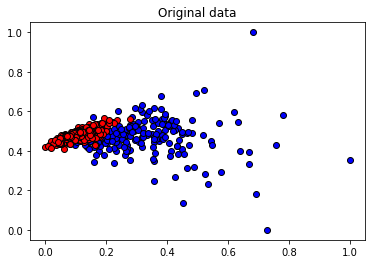

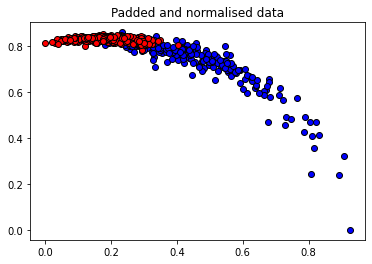

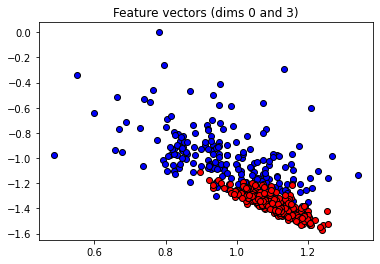

In [46]:
# Configurations for plotting
color_mapping = {
    -1:"b",
    1:"r",
}

# Plotting out the impact of transformations
plt.figure()
for cat in color_mapping:
    plt.scatter(X[:,0][Y == cat], X[:, 1][Y ==cat], c=color_mapping[cat], edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
for cat in color_mapping:
    plt.scatter(X_norm[:,0][Y == cat], X_norm[:, 1][Y ==cat], c=color_mapping[cat], edgecolors="k")
plt.title("Padded and normalised data")
plt.show()

plt.figure()
for cat in color_mapping:
    plt.scatter(features[:,0][Y == cat], features[:, 3][Y ==cat], c=color_mapping[cat], edgecolors="k")
plt.title("Feature vectors (dims 0 and 3)")
plt.show()

In [47]:
## Splitting train and test ##
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))

# Training Data
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]

# Test Data
feats_test = features[index[num_train:]]
Y_test = Y[index[num_train:]]

# For plotting
X_train = X[index[:num_train]]
X_test = X[index[num_train:]]

feats_train.shape, Y_train.shape, feats_test.shape, Y_test.shape

((426, 5), (426,), (143, 5), (143,))

Setting up the Quantum Circuit & Model

In [48]:
## Creating a device ##
dev = qml.device("default.qubit", wires=2)

## Defining layer func ##
def layer(W):
    """
    W (array): weights
    """
    qml.Rot(W[0,0], W[0,1], W[0,2], wires=0) # Rotate wire 0 by weights
    qml.Rot(W[1,0], W[1,1], W[1,2], wires=1) # Rotate wire 1 by weights
    qml.CNOT(wires=[0,1]) # Entangle wire 0 and 1

## Creating Model Circuit ##
@qml.qnode(dev)
def circuit(weights, angles):
    statepreperation(angles)

    for W in weights:
        layer(W)
    
    return qml.expval(qml.PauliZ(0)) # PauliZ measures and rotates back

## Creating Model ##
def variational_classifier(var, angles):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles) + bias

## Defining Cost Function ##
def cost(weights, features, labels):
    predictions = [variational_classifier(weights, f) for f in features]
    return square_loss(labels, predictions)

## Define Square Loss ##
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

## Define measurement metric ##
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [50]:
num_qubits = 2
num_layers = 4

## Initalising the weights ##
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

In [51]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# Train the classifier
var = var_init
for iteration in range(50):

    # Update the weights 
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions
    predictions_train = [np.sign(variational_classifier(var, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, f)) for f in feats_test]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_test, predictions_val)

    print(
        "Iter: {:5d} | Cost : {:0.7f} | Acc train: {:0.7f} | Acc Val : {:0.7f}".format(iteration+1, cost(var, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost : 1.0926315 | Acc train: 0.6244131 | Acc Val : 0.6363636
Iter:     2 | Cost : 1.0712031 | Acc train: 0.6244131 | Acc Val : 0.6363636
Iter:     3 | Cost : 1.0512853 | Acc train: 0.6244131 | Acc Val : 0.6363636
Iter:     4 | Cost : 1.0348972 | Acc train: 0.6244131 | Acc Val : 0.6363636
Iter:     5 | Cost : 1.0223992 | Acc train: 0.6244131 | Acc Val : 0.6433566
Iter:     6 | Cost : 1.0140891 | Acc train: 0.6244131 | Acc Val : 0.6433566
Iter:     7 | Cost : 1.0051318 | Acc train: 0.6244131 | Acc Val : 0.6433566
Iter:     8 | Cost : 0.9959534 | Acc train: 0.6267606 | Acc Val : 0.6433566
Iter:     9 | Cost : 0.9860092 | Acc train: 0.6267606 | Acc Val : 0.6503497
Iter:    10 | Cost : 0.9764240 | Acc train: 0.6314554 | Acc Val : 0.6503497
Iter:    11 | Cost : 0.9695745 | Acc train: 0.6431925 | Acc Val : 0.6503497
Iter:    12 | Cost : 0.9648740 | Acc train: 0.6643192 | Acc Val : 0.6713287
Iter:    13 | Cost : 0.9546405 | Acc train: 0.6666667 | Acc Val : 0.6783217
Iter:    14 

In [52]:
## Compare against a classical classifier ##
cSVC = SVC()
cSVC.fit(X_train,Y_train)
y_pred = cSVC.predict(X_test)
print("Classic SVC Acc Val: ",accuracy(Y_test,y_pred))

Classic SVC Acc Val:  0.9230769230769231


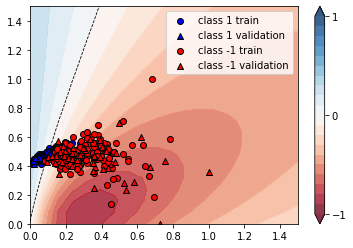

In [54]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(var, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_test[:, 0][Y_test == 1],
    X_test[:, 1][Y_test == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_test[:, 0][Y_test == -1],
    X_test[:, 1][Y_test == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()